# Coupling to the interface

This is an example of how to use Dune-MMesh and solve coupled problems on the bulk and interface grid.

## Grid creation

We use the [horizontal](grids/horizontal.rst) grid file that contains an interface $\Gamma = [0.25, 0.75] \times {0.5}$ embedded in a domain $\Omega = [0,1]^2$. Grid creation from a mesh file works as follow.

In [1]:
from dune.grid import reader
from dune.mmesh import mmesh
dim = 2
file = "grids/horizontal.msh"
gridView  = mmesh((reader.gmsh, file), dim)
igridView = gridView.hierarchicalGrid.interfaceGrid

## Solve a problem on the bulk grid

Let us solve the Poisson equation

\begin{align}
-\Delta u = f & \qquad \text{in}\ \Omega
\end{align}

on the bulk grid. We use the manufactured solution $\hat u = \sin(4 \pi x y)$ and therefore apply the source term $f = -\operatorname{div}( \nabla \hat u )$. The weak form of the problem above reads
\begin{align}
\int_\Omega \nabla u \cdot \nabla v~dx &= \int_\Omega f v~dx
\end{align}
for all corresponding test functions $v$. This can be implemented as follows.

In [2]:
from ufl import *
from dune.ufl import DirichletBC
from dune.fem.space import lagrange
from dune.fem.scheme import galerkin
from dune.fem.function import integrate

space = lagrange(gridView, order=3)
u = TrialFunction(space)
v = TestFunction(space)

x = SpatialCoordinate(space)
exact = sin(x[0]*x[1]*4*pi)
f = -div(grad(exact))

a = inner(grad(u), grad(v)) * dx
b = f * v * dx

scheme = galerkin([a == b, DirichletBC(space, exact)], solver=("suitesparse", "umfpack"))
uh = space.interpolate(0, name="solution")
scheme.solve(target=uh)

def L2(u1, u2):
    return sqrt(integrate(u1.grid, (u1-u2)**2, order=5))

L2(uh, exact)

5.628259763933402e-07

## Solve a problem on the interface

We can solve similar problem on the interface $\Gamma$ like
\begin{align}
-\Delta u_\Gamma = f & \qquad \text{in}\ \Gamma
\end{align}
with the weak form
\begin{align}
\int_\Gamma \nabla u_\Gamma \cdot \nabla v_\Gamma~dx &= \int_\Gamma f v_\Gamma~dx
\end{align}
for all corresponding test functions $v_\Gamma$.

In [3]:
ispace = lagrange(igridView, order=3)
iuh = ispace.interpolate(0, name="isolution")

iu = TrialFunction(ispace)
iv = TestFunction(ispace)

ix = SpatialCoordinate(ispace)
iexact = sin(0.5*ix[dim-2]*4*pi)
iF = -div(grad(iexact))
    
ia = inner(grad(iu), grad(iv)) * dx
ib = iF * iv * dx

ischeme = galerkin([ia == ib, DirichletBC(ispace, iexact)])
ischeme.solve(target=iuh)
L2(iuh, iexact)

5.807742030532398e-08

We can use the `plotPointData` function to visualize the solution of both grids.

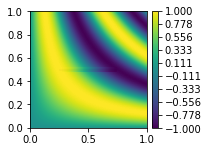

In [4]:
import matplotlib.pyplot as plt
from dune.fem.plotting import plotPointData as plot

figure = plt.figure(figsize=(3,3))
plot(uh, figure=figure, gridLines=None)
plot(iuh, figure=figure, linewidth=0.04, colorbar=None)

## Couple bulk to surface

Dune-MMesh makes it possible to compute traces of discrete functions on $\Omega$ along $\Gamma$.

In [5]:
from dune.mmesh import trace
tr = avg(trace(uh))
ib = inner(grad(tr), grad(iv)) * dx

iuh.interpolate(0)
ischeme = galerkin([ia == ib, DirichletBC(ispace, avg(trace(uh)))])
ischeme.solve(target=iuh)
L2(iuh, iexact)

4.266679479547976e-08

## Couple surface to bulk

Similarly, we can evaluate a discrete function on $\Gamma$ at the skeleton of the triangulation of $\Omega$.

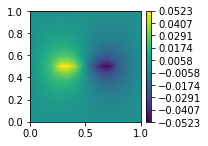

In [6]:
from dune.mmesh import skeleton

sk = skeleton(iuh)
b = avg(sk) * avg(v) * dS

uh.interpolate(0)
scheme = galerkin([a == b, DirichletBC(space, 0)])
scheme.solve(target=uh)

figure = plt.figure(figsize=(3,3))
plot(uh, figure=figure, gridLines=None)

## Compute jump of gradient of traces

We can use trace and skeleton within UFL expressions. This is useful when using jump and average operators, but also to compute gradients and more. Together with the utility function `normals`, which returns the positive normal of the underlying bulk facet, we can determine the orientation of the restricted values.

In [7]:
from dune.mmesh import normals
inormal = normals(igridView)
jmp = jump(grad(trace(uh)), inormal)